# Image Preprocessing & Moon Localization

This notebook processes RAW telescope images to prepare for orbital analysis. It includes loading and filtering astroimages, detecting Jupiter’s moons using brightness thresholds and DAOStarFinder, and accurately localizing Jupiter via brightness-weighted centroiding. The output is a cleaned, cropped image with identified coordinates for Jupiter and its moons, ready for coordinate transformation and orbit modeling.

### Load and preprocess RAW image of Jupiter

This block loads the first `.CR2` RAW image, converts it to grayscale, applies Gaussian smoothing to reduce noise, thresholds low-intensity pixels, and crops the image to focus on Jupiter and its moons. It then displays the original, cropped, and thresholded images for inspection.


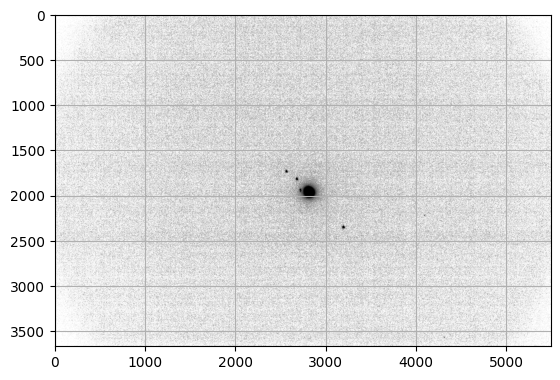

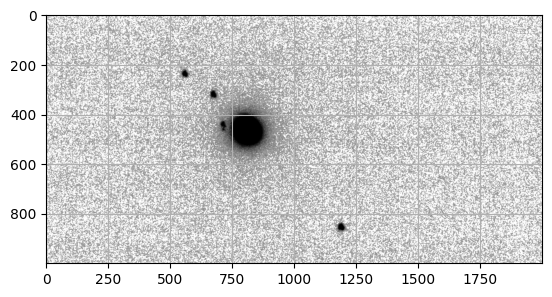

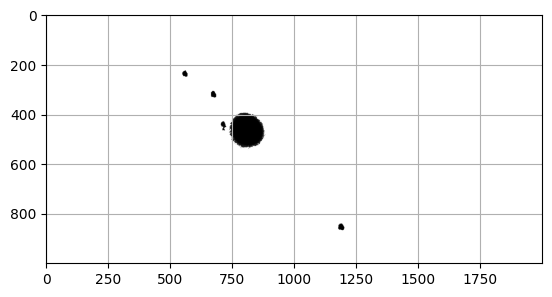

In [6]:
import os
import rawpy
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter

from photutils.aperture import CircularAperture
from matplotlib.colors import LogNorm
import numpy as np
from photutils.detection import DAOStarFinder


# Specify the directory containing your RAW files
directory_path = 'cr2'
# List all files in the directory
files = os.listdir(directory_path)
# Find the first file with a ".cr2" extension
raw_file = next(file for file in files if file.lower().endswith('.cr2'))
# Construct the full path to the RAW file
raw_file_path = os.path.join(directory_path, raw_file)
# Load the RAW file
raw = rawpy.imread(raw_file_path)

rgb = raw.postprocess()
image_data = rgb[:,:,1]
#image_data = image_data[2000:-500,2500:-1500]
image_data = image_data[:,:]

# Apply median filter to remove background noise
#filtered_image = median_filter(image_data, size=3)

# Convert to grayscale
data = np.mean(rgb, axis=-1)

# Apply Gaussian blur
data = gaussian_filter(data, sigma=1.0)

data[data<1*np.median(data)]=0

positive_indices = np.argwhere(data > 210)

# Get the minimum and maximum row and column indices of positive values
min_row, max_row = positive_indices[:, 0].min(), positive_indices[:, 0].max()
min_col, max_col = positive_indices[:, 1].min(), positive_indices[:, 1].max()

# Add a margin of 20 pixels
min_row = max(0, min_row - 20)
max_row = min(data.shape[0] - 1, max_row + 20)
min_col = max(0, min_col - 20)
max_col = min(data.shape[1] - 1, max_col + 20)

# Crop the array using the calculated indices
#data_cut = data[min_row:max_row + 1, min_col:max_col + 1]
data_cut = data

#Mehr data reduction
data1=data.copy()
data1[data1<210]=0

positive_indices1 = np.argwhere(data1 > 210)

# Get the minimum and maximum row and column indices of positive values
min_row1, max_row1 = positive_indices1[:, 0].min(), positive_indices1[:, 0].max()
min_col1, max_col1 = positive_indices1[:, 1].min(), positive_indices1[:, 1].max()

# Add a margin of 20 pixels
min_row1 = max(0, min_row1 - 20)
max_row1 = min(data1.shape[0] - 1, max_row1 + 20)
min_col1 = max(0, min_col1 - 20)
max_col1 = min(data1.shape[1] - 1, max_col1 + 20)

# Crop the array using the calculated indices
#data_cut1 = data1[min_row1:max_row1 + 1, min_col1:max_col1 + 1]
#data_cut1 = data_cut1

# Manual cropping
#data = data[1000:2500,2500:3600]
data_cut = data_cut[1500:2500,2000:4000]
data1 = data1[1500:2500,2000:4000]



plt.figure()
plt.imshow(data,cmap='Greys')
#plt.axis('off') # to hide the axis
plt.grid()
plt.show()

plt.figure()
plt.imshow(data_cut,cmap='Greys')
#plt.axis('off') # to hide the axis
plt.grid()
plt.show()

plt.figure()
plt.imshow(data1,cmap='Greys')
#plt.axis('off') # to hide the axis
plt.grid()
plt.show()





### Manual inspection for cropping regions near Jupiter

This block (currently commented out) was used to manually inspect the raw image and determine coordinates of bright regions too close to Jupiter, helping define exclusion zones for later analysis.


In [ ]:
#for manually subtract cutting from points too close to jupiter

#coord = np.array([2066-1500,2777-2000])

#print(coord)

#import rawpy
#import matplotlib.pyplot as plt

#raw = rawpy.imread('IMG_6487.CR2')

#rgb = raw.postprocess()
#data = rgb[:,:,1]

#plt.figure()
#plt.imshow(data)
#plt.axis('off') # to hide the axis
#plt.grid()
#plt.show()

### Detect moon candidates using DAOStarFinder

This block applies sigma-clipped statistics to estimate background noise, then detects bright sources (moons) in the cropped image using `DAOStarFinder`. A mask is applied to avoid detecting Jupiter. The detected source positions are plotted with circular apertures.


(75.15089562763933, 104.04430655529201, 56.94354351863287)
 id xcentroid ycentroid sharpness roundness1 ... npix sky   peak  flux  mag 
--- --------- --------- --------- ---------- ... ---- ---- ------ ---- -----
  1    560.44    240.20      0.27       0.39 ...  961 0.00 150.93 1.33 -0.31
  2    674.06    321.71      0.31       0.21 ...  961 0.00 150.95 1.31 -0.30
  3    714.21    442.88      0.32       0.21 ...  961 0.00 150.95 1.04 -0.04
  4   1189.32    853.87      0.32       0.02 ...  961 0.00 150.62 1.30 -0.28
[[ 560.43749392  240.20029788]
 [ 674.06367385  321.71212703]
 [ 714.21032093  442.87674356]
 [1189.31941999  853.87037436]]


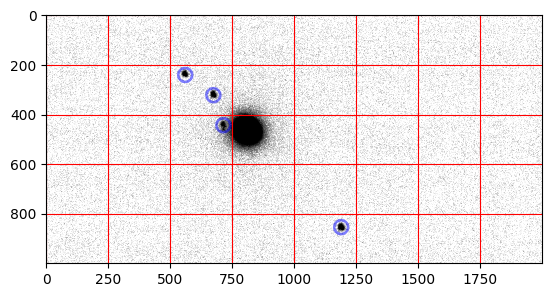

In [8]:
from astropy.stats import sigma_clipped_stats

image_data = data_cut

mean, median, std = sigma_clipped_stats(image_data, sigma = 3.0)
print((mean, median, std))


daofind = DAOStarFinder(fwhm = 25.0, threshold = 14*std)
source = daofind(image_data - median)

for col in source.colnames:
    if col not in ('id', 'npix'):
        source[col].info.format = '%.2f'
source.pprint(max_width = 76)


mask = np.zeros(image_data.shape, dtype=bool)
mask[0:800, :] = False
mask[:,0:800] = False
source = daofind(image_data - median, mask=mask)

positions = np.transpose((source['xcentroid'], source['ycentroid']))
apertures = CircularAperture(positions, r= 5.0)
plt.imshow(image_data, cmap='Greys', norm=LogNorm(), interpolation='nearest')
apertures.plot(color='blue', lw=10, alpha = 0.5)
plt.grid(color='red')

print(positions)

### Compute Jupiter's centroid via iterative brightness weighting

This block defines a centroid function to locate Jupiter by computing the brightness-weighted center of the image. A circular mask is applied to isolate Jupiter, improving centroid accuracy. The final position is plotted alongside the detected moons.


In [9]:
def centre(data):
    y, x = np.indices(data.shape)
    
    # Schwerpunkt berechnen
    x_centroid = np.sum(x * data) / np.sum(data)
    y_centroid = np.sum(y * data) / np.sum(data)
    print(f"Schwerpunkt der Helligkeit: (x, y) = ({x_centroid}, {y_centroid})")
    return (x_centroid,y_centroid)

Schwerpunkt der Helligkeit: (x, y) = (808.822100111754, 469.16903692586544)
Schwerpunkt der Helligkeit: (x, y) = (807.2901198576506, 466.65434518544936)


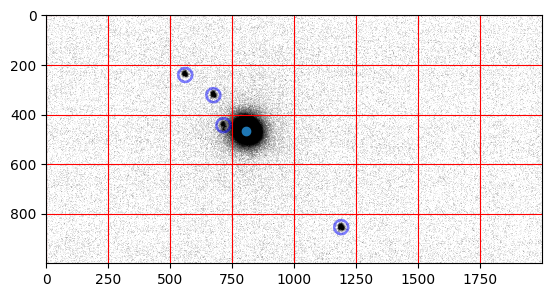

In [12]:
from matplotlib.colors import LogNorm

data_cut1 = data1

x_centroid1,y_centroid1=centre(data_cut1)

# Create a grid of x and y coordinates
y_indices, x_indices = np.indices(data_cut1.shape)

# Calculate the radial distance from the point (x, y)
radial_dist = np.sqrt((x_indices - x_centroid1)**2 + (y_indices - y_centroid1)**2)

# Create a mask where the radial distance is greater than r
mask = radial_dist > 100

# Set the values to zero where the mask is True
data_morecut=data_cut1.copy()
data_morecut[mask] = 0

x_centroid,y_centroid=centre(data_morecut)

jupiter=np.array([x_centroid,y_centroid])

plt.imshow(data_cut, cmap='Greys', norm=LogNorm(), interpolation='nearest')
plt.plot(jupiter[0],jupiter[1],"o")
apertures.plot(color='blue', lw=10, alpha = 0.5)
plt.grid(color='red')
plt.savefig('coord.png')